In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#!pip uninstall numpy
!pip install numpy==1.9
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install bayesian-optimization
!pip install color-it
!pip install --upgrade scipy networkx

#!pip install dgl -f https://data.dgl.ai/wheels/repo.html
#!pip install dgl-cu111 dglgo -f https://data.dgl.ai/wheels/repo.html
#!pip install dive-into-graphs
#!pip install pydig

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
  Running setup.py clean for numpy
Failed to build numpy
ERROR: Could not build wheels for numpy, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 25.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from colorit import *
from torch._C import dtype

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch_geometric.nn as gnn
import torch.nn.functional as F
from torch.nn import Linear
from sklearn.model_selection import train_test_split
import numpy as np
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool
from torch_geometric.datasets import TUDataset
from torch_geometric.data.batch import Batch
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor
import itertools


from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn import metrics
from bayes_opt import BayesianOptimization, UtilityFunction
from time import perf_counter

#. DGL
#import dgl
#import dgl.function as fn
#from dgl.data import GINDataset
#from dgl.nn import GNNExplainer as GNNExplainer_DGL
#from dgl.dataloading import GraphDataLoader
#from dgl.nn import AvgPooling

#. DIG
#from dig.xgraph.dataset import SynGraphDataset
#from dig.xgraph.method import PGExplainer
#from dig.xgraph.utils.compatibility import compatible_state_dict
#from dig.xgraph.method.subgraphx import PlotUtils
#from dig.xgraph.method.subgraphx import MCTS
#from torch_geometric.utils import to_networkx
#from dig.xgraph.method import GNNExplainer as GNNExplainer_DIG
#from dig.xgraph.models import GCN_2l
#from dig.xgraph.models import GlobalMeanPool

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Utilities**

In [4]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/Layers/'
sys.path.insert(0,py_path)
import matrix_util as Mat_Util

## **GCN_plus_GAP**

In [5]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
import GCN_plus_GAP as gcn_plus_gap_model

GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
eLu is Selected.
GCN_plus_GAP(
  (GConvs): ModuleList(
    (0-1): 2 x GCNConv(7, 7)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (readout): GlobalMeanPool()
  (ffn): Linear(in_features=7, out_features=2, bias=True)
)


## **DGCNN Model Call**

In [6]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
import DGCNN_layer as dgcnn_layer
import DGCNN_GNN_Layers as dgcnn_gnn_layers
import SortPooling_Layer as sortpooling_layer
import MLP_DGCNN as mlp_dgcnn
import DGCNN as dgcnn_model

## **DIFFPOOL Model Call**

In [7]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/Layers/'
sys.path.insert(0,py_path)
import Batched_GraphSage_Layer as batched_graphsage_layer
import Batched_DIFFPOOL_Assignment as batched_diffpool_assignment
import Batched_DIFFPOOL_Embedding as batched_diffpool_embedding
import Batched_DIFFPOOL_Layer as batched_diffpool_layer
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
import DIFFPOOL as diffpool_model

## **GIN Model Call**

In [8]:
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/Layers/'
sys.path.insert(0,py_path)
import GIN_MLP_Layers as gin_mlp_layers
import GIN as gin_model

In [9]:
Explainability_name = 'Evaluation of GNNs'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [10]:
import csv
##                 #Dataset_name, Model_name, Model_Description, Weight_Initializer, num_folds, EPOCHS, lr, DropOut_Rate, Bias, Batch, Loss_Function, mean(AUC_ROC), mean(AUC_PRC), mean(ACC), "Avg Runing Time[Epochs]"
Header = np.array(["Datset", "Model Name", "Model Description", "Weight_Initializer", "K-Fold", "Epochs", "LR", "DropOut Rate", "Bias", "Batch Size", "Loss Function", "AUC-ROC", "AUC-PRC", "Acc", "Avg Runing Time[Epochs]"])
#with open("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Experimental Results/GCN_plus_GAP/" + str("GCN_plus_GAP") + "__HyperParameters.csv", 'w') as outcsv:
#    writer = csv.DictWriter(outcsv, fieldnames = Header)
#    writer.writeheader()
with open("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Experimental Results/DGCNN/" + str("DGCNN") + "__HyperParameters.csv", 'w') as outcsv:
    writer = csv.DictWriter(outcsv, fieldnames = Header)
    writer.writeheader()
#with open("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Experimental Results/DIFFPOOL/" + str("DIFFPOOL") + "__HyperParameters.csv", 'w') as outcsv:
#    writer = csv.DictWriter(outcsv, fieldnames = Header)
#    writer.writeheader()
#with open("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Experimental Results/GIN/" + str("GIN") + "__HyperParameters.csv", 'w') as outcsv:
#    writer = csv.DictWriter(outcsv, fieldnames = Header)
#    writer.writeheader()

In [11]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
feat_size = dataset[0].x.shape[1]

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


## **K for DGCNN**

In [12]:
def get_hyperparameter_K_for_DGCNN(dataset):
    num_nodes_list = []
    for graph in dataset:
        num_nodes_list.append(len(graph.x))
    #print(num_nodes_list)
    #print(max(num_nodes_list))
    my_threshold = [[],[]]
    for threshold_size in range(max(num_nodes_list)):
        #x = [i for i in num_nodes_list if i > size]
        candidates = []
        for s in num_nodes_list:
            if s >= threshold_size:
                candidates.append(s)
                if round(len(candidates)/len(num_nodes_list), 0) >= 0.6:
                    my_threshold[0].append(threshold_size) # threshold values
                    my_threshold[1].append(round(len(candidates)/len(num_nodes_list), 0) >= 0.6) # fraction rate
                    #print("threshold_size: ", threshold_size, )
                    break
                else:
                    pass

        #print(round(len(candidates)/len(num_nodes_list)*100, 0), "%", "have more node count than ", threshold_size)
    return my_threshold[0][-1]

K_DGCNN_HyperParameter = get_hyperparameter_K_for_DGCNN(dataset)
print(K_DGCNN_HyperParameter)

17


## **DIFFPOOL new number of Nodes**

In [13]:
def diffpool_new_number_of_nodes(your_dataset):
    size_list = []
    for graph in your_dataset:
        size_list.append(len(graph.x))
    return max(size_list)
print(diffpool_new_number_of_nodes(dataset))

28


In [14]:
print("Number of Graphs: ", len(dataset))
print("Number of Node Features: ", dataset.num_node_features)
print("Number of Edge Features: ", dataset.num_edge_features)
#print("Number of Node Features: ", dataset.num_node_attributes)
#print("Number of Node Features: ", dataset.num_edge_attributes)
print("Number of Classes: ", dataset.num_classes)
count=0
for i in range(len(dataset)):
    count = count + len(dataset[i].edge_index[0])
print("Number of Edges: ", count)
data = dataset[0]
print(data)
#print(dataset.labels)

Number of Graphs:  188
Number of Node Features:  7
Number of Edge Features:  4
Number of Classes:  2
Number of Edges:  7442
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


In [15]:
def pick_your_graph(main_dataset, train_index_list, test_index_list):
    train_dataset = []
    test_dataset = []

    for index in train_index_list:
        train_dataset.append(main_dataset[index])
    for index in test_index_list:
        test_dataset.append(main_dataset[index])

    return train_dataset, test_dataset

In [16]:
def batching_data(train_dataset, test_dataset, BATCH_SIZE):
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_dataloader, test_dataloader

In [17]:
def get_your_dataset(num_folds, dataset, Batch_count_by_16):
    Train_Datasets_Index = []
    Test_Datasets_Index = []
    #num_folds = 3

    kf = KFold(n_splits=num_folds, shuffle=True)
    for train_index, test_index in kf.split(dataset):
        Train_Datasets_Index.append(train_index.tolist())
        Test_Datasets_Index.append(test_index.tolist())

    for k in range(num_folds):
        exec(f'Train_Dataset{k+1}, Test_Dataset{k+1} = pick_your_graph(dataset, Train_Datasets_Index[k], Test_Datasets_Index[k])')

    Train_Datasets_Batched = []
    Test_Datasets_Batched = []
    Train_Datasets = []
    Test_Datasets = []


    if Batch_count_by_16 != 0:
        for i in range(num_folds):
            exec(f'Train_Dataset_Batched{i+1}, Test_Dataset_Batched{i+1} = batching_data(Train_Dataset{i+1}, Test_Dataset{i+1}, Batch_count_by_16*16)')
        for i in range(num_folds):
            exec(f'Train_Datasets_Batched.append(Train_Dataset_Batched{i+1})')
            exec(f'Test_Datasets_Batched.append(Test_Dataset_Batched{i+1})')
        #print("get your data done")
        return Train_Datasets_Batched, Test_Datasets_Batched
    else:
        for i in range(num_folds):
            exec(f'Train_Datasets.append(Train_Dataset{i+1})')
            exec(f'Test_Datasets.append(Test_Dataset{i+1})')

        return Train_Datasets, Test_Datasets

In [ ]:
#num_folds = 3
#Train_Datasets, Test_Datasets = get_your_dataset(num_folds, dataset)

#for i in range(num_folds):
#  print(np.shape(Train_Datasets[i]), np.shape(Test_Datasets[i]))



In [18]:
feat_size = dataset[0].x.shape[1]
print(feat_size)
#DGL_Model = Graph_Model(feat_size, dataset.gclasses)

7


# **GCN MODEL**

In [ ]:
#class GNNPool(nn.Module):
#    def __init__(self):
#        super().__init__()

In [ ]:
#class GlobalMeanPool(GNNPool):

#    def __init__(self):
#        super().__init__()

#    def forward(self, x, batch):
#        return gnn.global_mean_pool(x, batch)

In [ ]:
#class IdenticalPool(GNNPool):
#
#    def __init__(self):
#        super().__init__()

#    def forward(self, x, batch):
#        return x

In [ ]:
#class GNNBasic(torch.nn.Module):
#    def __init__(self):
#        super().__init__()
#
#    def arguments_read(self, *args, **kwargs):
#
#        data: Batch = kwargs.get('data') or None
#
#        if not data:
#            if not args:
#                assert 'x' in kwargs
#                assert 'edge_index' in kwargs
#                x, edge_index = kwargs['x'], kwargs['edge_index'],
#                batch = kwargs.get('batch')
#                if batch is None:
#                    batch = torch.zeros(kwargs['x'].shape[0], dtype=torch.int64, device=x.device)
#            elif len(args) == 2:
#                x, edge_index = args[0], args[1]
#                batch = torch.zeros(args[0].shape[0], dtype=torch.int64, device=x.device)
#            elif len(args) == 3:
#                x, edge_index, batch = args[0], args[1], args[2]
#            else:
#                raise ValueError(f"forward's args should take 2 or 3 arguments but got {len(args)}")
#        else:
#            x, edge_index, batch = data.x, data.edge_index, data.batch
#
#        return x, edge_index, batch


In [ ]:
#class GCNConv(gnn.GCNConv):
#
#    def __init__(self, *args, **kwargs):
#        super().__init__(*args, **kwargs)
#        self.edge_weight = None
#        self.weight = nn.Parameter(self.lin.weight.data.T.clone().detach())
#
#    def forward(self, x: Tensor, edge_index: Adj,
#                edge_weight: OptTensor = None) -> Tensor:
#        """"""
#
#        if self.normalize and edge_weight is None:
#            if isinstance(edge_index, Tensor):
#                cache = self._cached_edge_index
#                if cache is None:
#                    edge_index, edge_weight = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
#                        edge_index, edge_weight, x.size(self.node_dim),
#                        self.improved, self.add_self_loops, dtype=x.dtype)
#                    if self.cached:
#                        self._cached_edge_index = (edge_index, edge_weight)
#                else:
#                    edge_index, edge_weight = cache[0], cache[1]
#
#            elif isinstance(edge_index, SparseTensor):
#                cache = self._cached_adj_t
#                if cache is None:
#                    edge_index = gnn.conv.gcn_conv.gcn_norm(  # yapf: disable
#                        edge_index, edge_weight, x.size(self.node_dim),
#                        self.improved, self.add_self_loops, dtype=x.dtype)
#                    if self.cached:
#                        self._cached_adj_t = edge_index
#                else:
#                    edge_index = cache
#
#        edge_weight.requires_grad_(True)
#
#        x = torch.matmul(x, self.weight)
#
#        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
#                             size=None)
#
#        if self.bias is not None:
#            out += self.bias
#
#        self.edge_weight = edge_weight
#
#        return out
#
#    def propagate(self, edge_index: Adj, size: Size = None, **kwargs):
#        size = self.__check_input__(edge_index, size)
#
#        # Run "fused" message and aggregation (if applicable).
#        if (isinstance(edge_index, SparseTensor) and self.fuse
#                and not self._explain):
#            coll_dict = self.__collect__(self.__fused_user_args__, edge_index,
#                                         size, kwargs)
#
#            msg_aggr_kwargs = self.inspector.distribute(
#                'message_and_aggregate', coll_dict)
#            out = self.message_and_aggregate(edge_index, **msg_aggr_kwargs)
#
#            update_kwargs = self.inspector.distribute('update', coll_dict)
#            return self.update(out, **update_kwargs)
#
#        elif isinstance(edge_index, Tensor) or not self.fuse:
#            coll_dict = self.__collect__(self.__user_args__, edge_index, size,
#                                         kwargs)
#
#            msg_kwargs = self.inspector.distribute('message', coll_dict)
#            out = self.message(**msg_kwargs)
#
#            if self._explain:
#                edge_mask = self.__edge_mask__
#                if out.size(self.node_dim) != edge_mask.size(0):
#                    loop = edge_mask.new_ones(size[0])
#                    edge_mask = torch.cat([edge_mask, loop], dim=0)
#                assert out.size(self.node_dim) == edge_mask.size(0)
#                out = out * edge_mask.view([-1] + [1] * (out.dim() - 1))
#
#            aggr_kwargs = self.inspector.distribute('aggregate', coll_dict)
#            out = self.aggregate(out, **aggr_kwargs)
#
#            update_kwargs = self.inspector.distribute('update', coll_dict)
#            return self.update(out, **update_kwargs)


In [ ]:
#class GCN_2l_Model(GNNBasic):
#
#    def __init__(self, model_level, dim_node, dim_hidden, dim_output, dropout_rate, Bias, Weight_Initializer):
#        super().__init__()
#        num_layer = 2
#
#        self.gconv1 = GCNConv(dim_node, dim_hidden, bias=Bias)
#        self.relu1 = nn.ReLU()
#
#        self.gconv2 = GCNConv(dim_hidden, dim_hidden, bias=Bias)
#        self.relu2 = nn.ReLU()
#
#        if model_level == 'node':
#            self.readout = IdenticalPool()
#        else:
#            self.readout = GlobalMeanPool()
#
#        self.ffn = nn.Linear(dim_hidden, dim_output, bias=Bias)
#
#        self.dropout = nn.Dropout(p=dropout_rate)
#        self.initialize_weights(Weight_Initializer, Bias)
#
#    def initialize_weights(model, Weight_Initializer, Bias):
#      # 1. Xavier Uniform.  2. Kaiming.  3. uniform (0,0.1std)
#      if Weight_Initializer == 1:
#          for m in model.modules():
#                if isinstance(m, (nn.Linear)):
#                    nn.init.xavier_normal_(m.weight)
#                    if Bias:
#                        m.bias.data.zero_()
#                        #print("done")
#                if isinstance(m, (GCNConv)):
#                    nn.init.xavier_normal_(m.weight)
#                    if Bias:
#                        m.bias.data.zero_()
#                        #print("here")
#
#      if Weight_Initializer == 2:
#        for m in model.modules():
#            if isinstance(m, (nn.Linear)):
#                nn.init.kaiming_normal_(m.weight)
#                if Bias:
#                    m.bias.data.zero_()
#                    #print("done")
#            if isinstance(m, (GCNConv)):
#                nn.init.kaiming_normal_(m.weight)
#                if Bias:
#                    m.bias.data.zero_()
#                    #print("here")
#
#      if Weight_Initializer == 3:
#          for m in model.modules():
#              if isinstance(m, (nn.Linear)):
#                  nn.init.normal_(m.weight.data, 0.0, 0.1)
#                  if Bias:
#                      m.bias.data.zero_()
#                      print("done")
#              if isinstance(m, (GCNConv)):
#                  nn.init.normal_(m.weight.data, 0.0, 0.1)
#                  if Bias:
#                      m.bias.data.zero_()
#                      #print("here")
#
#    def forward(self, *args, **kwargs) -> torch.Tensor:
#        """
#        :param Required[data]: Batch - input data
#        :return:
#        """
#        x, edge_index, batch = self.arguments_read(*args, **kwargs)
#
#        post_conv1 = self.relu1(self.gconv1(x, edge_index))
#        post_conv1 = self.dropout(post_conv1)
#
#        post_conv2 = self.relu2(self.gconv2(post_conv1, edge_index))
#        post_conv2 = self.dropout(post_conv1)
#        out_readout = self.readout(post_conv2, batch)
#
#        #print(np.shape(out_readout))
#        out = self.ffn(out_readout)
#
#        return out, post_conv2, post_conv1
#
#
#    def get_emb(self, *args, **kwargs) -> torch.Tensor:
#        x, edge_index, batch = self.arguments_read(*args, **kwargs)
#
#        post_conv1 = self.relu1(self.gconv1(x, edge_index))
#        post_conv2 = self.relu2(self.gconv2(x, edge_index))
#
#        return post_conv2

In [ ]:
#def initialize_weights(model):
#  # Initializes weights according to the DCGAN paper
#  for m in model.modules():
#    if isinstance(m, (nn.Linear)):
#      nn.init.normal_(m.weight.data, 0.0, 0.01)
#      #print("done")
#    if isinstance(m, (GCNConv)):
#      #print("here")
#      nn.init.normal_(m.weight.data, 0.0, 0.01)

In [ ]:
#import sys
#py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
#sys.path.insert(0,py_path)
#import Models_for_GNN as Graph_Network

#GNN_Model_example = gcn_plus_gap_model.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph',
#                                                    input_dim=7, hidden_dim=7, output_dim=2,
#                                                    num_hid_layers=2, Bias=True, act_fun='eLu',
#                                                    Weight_Initializer=1, dropout_rate=0.0)
#print(GNN_Model_example)
#print("====================================================================")
#print(GNN_Model_example.__class__.__name__)

In [19]:
def number_of_new_clusters(dataset):
    length_list = []
    for i in range(len(dataset)):
        sum = sum + len(dataset[i].x)
        length_list.append(len(dataset[i].x))
    return length_list

In [20]:
def Models_K_Folds(model_name, num_folds, dataset, dropout_rate, Bias, winit, act_fun):

    if model_name == "GCN_plus_GAP":
        Models = []
        #global act_for_GCN
        #act_for_GCN = "eLu"
        for i in range(num_folds):
            exec(f'GCN_Model_{i+1} = gcn_plus_gap_model.GCN_plus_GAP(model_name="GCN_plus_GAP", act_fun=act_fun, model_level="graph", input_dim=7, hidden_dim=7, output_dim=2, num_hid_layers=2, Bias=Bias, Weight_Initializer=winit, dropout_rate=dropout_rate)')
            exec(f'Models.append(GCN_Model_{i+1})')
            #exec(f'initialize_weights(GCN_Model_{i+1})')
    elif model_name == "DGCNN":
        Models = []
        k=K_DGCNN_HyperParameter
        node_feat_size = feat_size
        for i in range(num_folds):
            exec(f'DGCNN_Model_{i+1} = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, mlp_act_fun="ReLu", dgcnn_act_fun="tanh", mlp_dropout_rate=dropout_rate, Weight_Initializer=winit, Bias=Bias, dgcnn_k=k, node_feat_size=node_feat_size, hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])')
            exec(f'Models.append(DGCNN_Model_{i+1})')
    elif model_name == "DIFFPOOL":
        Models = []
        node_feat_size = feat_size
        hid_dim = 64
        new_num_nodes = 7
        for i in range(num_folds):
            exec(f'DIFFPOOL_Model_{i+1} = diffpool_model.DIFFPOOL_Model(embedding_input_dim=7, embedding_num_block_layers=1, embedding_hid_dim=64, new_feature_size=64, assignment_input_dim=7, assignment_num_block_layers=1, assignment_hid_dim=64, max_number_of_nodes=256, prediction_hid_layers=[50], concat_neighborhood=False, num_classes=2, Weight_Initializer=winit, Bias=Bias, dropout_rate=dropout_rate, normalize_graphsage=False, aggregation="mean", act_fun=act_fun, concat_diffpools_outputs=True, num_pooling=1, pooling="mean")')
            exec(f'Models.append(DIFFPOOL_Model_{i+1})')
    elif model_name == "GIN":
        Models = []
        node_feat_size = feat_size
        mlp_hid_dim = 16
        mlp_output_dim = 7
        for i in range(num_folds):
            exec(f'GIN_Model_{i+1} = gin_model.GIN_Model(num_mlp_layers=4, Bias=Bias, num_slp_layers=2, mlp_input_dim=node_feat_size, mlp_hid_dim=mlp_hid_dim, mlp_output_dim=mlp_output_dim, mlp_act_fun=act_fun, num_classes=2, dropout_rate=dropout_rate, Weight_Initializer=winit)')
            exec(f'Models.append(GIN_Model_{i+1})')


    #exec(f'print(GCN_Model_{1})')
    #exec(f'out, post_conv2, post_conv1 = GCN_Model_{1}(dataset[0].x, dataset[0].edge_index, dataset[0].batch)')
    #exec(f'print(out)')
    #GCN_Model_1.eval()

    #out1, post_conv2, post_conv1 = GCN_Model_1(dataset[0].x, dataset[0].edge_index, dataset[0].batch)
    #print(out)

    return Models

In [ ]:
#Models = Models_K_Folds(3, dataset, 0.5, True, 1)
#net = GCN_2l_Model(model_level="graph", dim_node=feat_size, dim_hidden=feat_size, dim_output=dataset.num_classes, dropout_rate=0.5, Bias=True, act_fun='eLu', Weight_Initializer=1)

#initialize_weights(net)
#print(len(Models))

In [21]:
def Optimizers_K_Fold_and_LR(Model_name, models, num_folds, lr, weight_decay=1e-6):
    Optimizers = []
    if Model_name == 'GCN_plus_GAP':
        for i in range(num_folds):
            exec(f'GCN_Model_Optimizer_{i+1} = torch.optim.Adam(models[i].parameters(), lr=lr, weight_decay=weight_decay)')
            exec(f'Optimizers.append(GCN_Model_Optimizer_{i+1})')
    elif Model_name == "DGCNN":
        for i in range(num_folds):
            exec(f'DGCNN_Model_Optimizer_{i+1} = torch.optim.Adam(models[i].parameters(), lr=lr, weight_decay=weight_decay)')
            exec(f'Optimizers.append(DGCNN_Model_Optimizer_{i+1})')
    elif Model_name == "DIFFPOOL":
        for i in range(num_folds):
            exec(f'DIFFPOOL_Model_Optimizer_{i+1} = torch.optim.Adam(models[i].parameters(), lr=lr, weight_decay=weight_decay)')
            exec(f'Optimizers.append(DIFFPOOL_Model_Optimizer_{i+1})')
    elif Model_name == "GIN":
        for i in range(num_folds):
            exec(f'GIN_Model_Optimizer_{i+1} = torch.optim.Adam(models[i].parameters(), lr=lr, weight_decay=weight_decay)')
            exec(f'Optimizers.append(GIN_Model_Optimizer_{i+1})')
    return Optimizers

In [22]:
x = torch.rand(10).reshape(2, 5).float()
print(x)
#print(torch.tensor_split(x, 2, dim=1)[0])
logits = F.log_softmax(x, dim=0)
print(logits)
prob = F.softmax(logits, dim=0)


print(prob[0])
print(prob[1])

tensor([[0.0628, 0.9120, 0.5193, 0.6050, 0.1947],
        [0.1493, 0.0644, 0.1444, 0.2905, 0.5990]])
tensor([[-0.7373, -0.3566, -0.5232, -0.5482, -0.9155],
        [-0.6508, -1.2042, -0.8981, -0.8627, -0.5113]])
tensor([0.4784, 0.7001, 0.5926, 0.5780, 0.4003])
tensor([0.5216, 0.2999, 0.4074, 0.4220, 0.5997])


In [23]:
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn((3,2), requires_grad=True)
print(input)
target = torch.empty((3,2)).random_(2)
print(target)
output = loss(m(input), target)
print(output)

tensor([[ 0.7520, -0.3643],
        [-0.6464, -0.2708],
        [ 0.3017,  1.1963]], requires_grad=True)
tensor([[0., 0.],
        [0., 1.],
        [0., 0.]])
tensor(0.8734, grad_fn=<BinaryCrossEntropyBackward0>)


In [24]:
a = torch.tensor([0.4691, 0.9589, 0.7529, 0.9564])
#b = torch.stack((1 - p, p), dim=-1)


def twodim_tensor_converter(mylabels):
    new_labels = []
    for i in mylabels:
        new_labels.append(torch.stack([1 - i, i], dim=-1).to(torch.float32) )
    return torch.stack(new_labels)
print(twodim_tensor_converter(a))

tensor([[0.5309, 0.4691],
        [0.0411, 0.9589],
        [0.2471, 0.7529],
        [0.0436, 0.9564]])


In [25]:
CrossEnt_criterion = torch.nn.CrossEntropyLoss()
MAE_criterion = torch.nn.L1Loss()
MSE_criterion = torch.nn.MSELoss()


def loss_calculations(preds, gtruth, Loss_Function):

    new_gtruth = twodim_tensor_converter(gtruth)

    if Loss_Function == 1:
        loss_per_epoch1 = CrossEnt_criterion(preds, new_gtruth).float()
        return loss_per_epoch1

    elif Loss_Function == 2:
        loss_per_epoch2 = MAE_criterion(preds, new_gtruth).float()
        return loss_per_epoch2

    elif Loss_Function == 3:
        loss_per_epoch3 = MSE_criterion(preds, new_gtruth).float()
        return loss_per_epoch3

In [26]:
def loading_model(load_index):
    GCN_Model = gcn_plus_gap_model.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph',
                                                input_dim=7, hidden_dim=7, output_dim=2,
                                                num_hid_layers=2, Bias=True, act_fun='eLu',
                                                Weight_Initializer=1, dropout_rate=0.0)
    GCN_Model_Optimizer = torch.optim.Adam(params = GCN_Model.parameters(), lr=0.001)
    checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
    GCN_Model.load_state_dict(checkpoint['model_state_dict'])
    GCN_Model.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']


    return GCN_Model, GCN_Model_Optimizer, epoch

In [27]:
def visualize_losses(Model_name, gcn_losses, epoch_history):
    gcn_losses_list = torch.stack(gcn_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(str(Model_name) + " Model Loss in Epoch: " + str(epoch_history))
    ax.plot(gcn_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+str(Model_name)+'/'+str(Model_name)+'__Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()

# **Training Configurations**

In [28]:
def train_step(Model_name, GNN_Model, Optimizer, Data, Loss_Function):
    if Model_name == "GCN_plus_GAP":
        GNN_Model_loss_batch = []
        GNN_Model.train()
        GNN_Model.zero_grad()
        for graph in Data:
            Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(graph)
            batch_loss = loss_calculations(soft, graph.y, Loss_Function)
            GNN_Model_loss_batch.append(batch_loss)
            batch_loss.backward()
            Optimizer.step()
        return torch.mean(torch.tensor(GNN_Model_loss_batch))


    elif Model_name == "DGCNN":
        GNN_Model_loss_batch = []
        GNN_Model.train()
        GNN_Model.zero_grad()
        for graph in Data:
            final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, ffn_1, dropout_ffn_1, ffn_2, softmaxed_ffn_2 = GNN_Model(graph, None)
            batch_loss = loss_calculations(softmaxed_ffn_2, graph.y, Loss_Function)
            GNN_Model_loss_batch.append(batch_loss)
            batch_loss.backward()
            Optimizer.step()
        return torch.mean(torch.tensor(GNN_Model_loss_batch))

    elif Model_name == "DIFFPOOL":
        GNN_Model_loss_batch = []
        GNN_Model.train()
        GNN_Model.zero_grad()
        for graph in Data:
            concatination_list_of_poolings, prediction_output = GNN_Model(graph, None)
            batch_loss = loss_calculations(prediction_output, graph.y, Loss_Function)
            GNN_Model_loss_batch.append(batch_loss)
            batch_loss.backward()
            Optimizer.step()
        return torch.mean(torch.tensor(GNN_Model_loss_batch))

    elif Model_name == "GIN":
        GNN_Model_loss_batch = []
        GNN_Model.train()
        GNN_Model.zero_grad()
        for graph in Data:
            mlps_output_embeds, mlps_output_embeds_stacked, mlp_outputs_globalSUMpooled, merged_mlps_output_embeds_reshaped, lin1_output, lin1_output_dropouted, lin2_output, lin2_output_softmaxed = GNN_Model(graph)
            batch_loss = loss_calculations(lin2_output_softmaxed, graph.y, Loss_Function)
            GNN_Model_loss_batch.append(batch_loss)
            batch_loss.backward()
            Optimizer.step()
        return torch.mean(torch.tensor(GNN_Model_loss_batch))

    else:
        print("Model Name is not appropriate")



#print("final_GNN_layer_output: ", final_GNN_layer_output, "sortpooled_embedings: ", sortpooled_embedings.size(), "output_conv1d_1: ",
#                  output_conv1d_1.size(), "maxpooled_output_conv1d_1: ", maxpooled_output_conv1d_1.size(), "output_conv1d_2: ", output_conv1d_2.size(),
#                  "to_dense: ", to_dense.size(), "output_h1: ", ffn_1.size(), "dropout_output_h1: ", dropout_ffn_1.size(), "output_h2: ", ffn_2.size(),
#                  "softmaxed_h2: ", softmaxed_ffn_2.size())


In [29]:
LOSS_Visualization_Parameter = 100
Model_Saving_Parameter = 100

In [30]:
def gnn_train(Model_name, EPOCHS, load_index, GNN_Model, Optimizer, Data, Loss_Function):
    GNN_Model_training_loss_per_epoch = []
    GNN_Model_training_time_per_epoch = []


    for epoch in range(EPOCHS):
        starting_time = perf_counter()
        GNN_Model_training_loss = train_step(Model_name, GNN_Model, Optimizer, Data, Loss_Function)
        print(f'Epoch: {epoch+1:03d}, Evaluation of {Model_name} Model, Loss: {GNN_Model_training_loss:.4f}')
        GNN_Model_training_loss_per_epoch.append(GNN_Model_training_loss)
        ending_time = perf_counter()
        GNN_Model_training_time_per_epoch.append(ending_time - starting_time)

        if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
            visualize_losses(Model_name, GNN_Model_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
            torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': Optimizer.state_dict(), 'loss': GNN_Model_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + str(Model_name) + '/' + str(Model_name) + "__model_classifier" + str(epoch + load_index + 1)+".pt")



    return GNN_Model_training_loss_per_epoch, GNN_Model_training_time_per_epoch

In [31]:
def sig(predictions):
    Preds = []
    for i in range(len(predictions)):
        Preds.append([1/(1 + np.exp(-predictions[i][0])), 1/(1 + np.exp(-predictions[i][1]))])
    return Preds

In [32]:
def Evaluations(y, pred):
    print("pred: ", pred)
    print("y: ", y)
    TPR_List = []
    FPR_List = []
    Precision_List = []
    NPV_List = []
    Acc_List = []
    F1Score_List = []

    threshold = np.linspace(1, 0, 10)

    for t in threshold:
        y_pred = np.zeros(y.shape[0])
        y_pred[pred >= t] = 1

        TN = y_pred[(y_pred == y) & (y == 0)].shape[0]
        TP = y_pred[(y_pred == y) & (y == 1)].shape[0]
        FP = y_pred[(y_pred != y) & (y == 0)].shape[0]
        FN = y_pred[(y_pred != y) & (y == 1)].shape[0]

        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        TNR = TN / (TN + FP)
        FNR = FN / (FN + TP)

        Precision = TP / (TP + FP + 1e-10)
        NPV = TN / (TN + FN + 1e-10)
        FDR = FP / (FP + TP + 1e-10)
        FOR = FN / (FN + TN + 1e-10)
        PLR = TPR / (FPR + 1e-10)
        NLR = FNR / (TNR + 1e-10)
        Acc = (TP + TN) / (TP + TN + FP + FN)
        F1Score = (2 * TP) / (2*TP + FP + FN)


        TPR_List.append(TPR)
        FPR_List.append(FPR)
        Precision_List.append(Precision)
        NPV_List.append(NPV)
        Acc_List.append(Acc)
        F1Score_List.append(F1Score)

    AUC_ROC = metrics.auc(FPR_List, TPR_List)
    AUC_ROC2 = metrics.roc_auc_score(y, pred)

    sorted_index_p = np.argsort(Precision_List)
    sorted_index_r = np.argsort(TPR_List)
    Precision_List =  np.array(Precision_List)[sorted_index_p]
    TPR_List = np.array(TPR_List)[sorted_index_r]
    AUC_PRC = metrics.auc(y=Precision_List, x=TPR_List)

    precision, recall, thresholds = metrics.precision_recall_curve(y, pred)
    sorted_index_p = np.argsort(precision)
    sorted_index_r = np.argsort(recall)
    precision =  np.array(precision)[sorted_index_p]
    recall = np.array(recall)[sorted_index_r]
    AUC_PRC2 = metrics.auc(y=precision, x=recall)
    ACC = metrics.accuracy_score(y, pred.round(), normalize=False)
    ACC2 = metrics.accuracy_score(y, pred.round(), normalize=True)

    return FPR_List, TPR_List, threshold, Precision_List, NPV_List, Acc_List, F1Score_List, AUC_ROC2, AUC_PRC2, ACC, ACC2

In [33]:
def detaching(test_dataset, GNN_Outputs, Batch):
    GNN_Outputs = list(itertools.chain.from_iterable(GNN_Outputs))
    #test_dataset = list(itertools.chain.from_iterable(test_dataset))
    #print("preds: ", GNN_Outputs)

    #print("reals: ", len(next(iter(test_dataset))))
    if Batch == 0:
        Real_Labels = []
        for i in range(len(test_dataset)):
            Real_Labels.append(test_dataset[i].y[0].detach().tolist())

        predictions = sig(GNN_Outputs)
        Predicted_Labels = []
        for i in range(len(predictions)):
            Predicted_Labels.append(predictions[i][1])

        return Evaluations(np.array(Real_Labels), np.array(Predicted_Labels))
    else:
        Real_Labels=[]
        for btch in test_dataset:
            Real_Labels.extend(btch.y.cpu().detach().numpy())
        Predicted_Labels = []
        for i in range(len(GNN_Outputs)):
            Predicted_Labels.append(GNN_Outputs[i][1])
        #print(Real_Labels)
        #print(Predicted_Labels)
        return Evaluations(np.array(Real_Labels), np.array(Predicted_Labels))

In [34]:
def GNN_Model_Evaluation(test_dataset, GNN_Model, Batch):
    GNN_Outputs = []
    GNN_Preds = []
    GNN_Outputs_Batched = []
    GNN_Preds_Batched = []
    #print(GNN_Model.__class__.__name__)
    if GNN_Model.__class__.__name__ == "GCN_plus_GAP":
        GNN_Model.eval()

        for batch_of_graphs in test_dataset:
            Output_of_Hidden_Layers_test, pooling_layer_output_test, ffn_output_test, gcn_soft_test = GNN_Model(batch_of_graphs)
            GNN_Model_test_pred = gcn_soft_test.argmax(dim=1)
            #print("gcn_soft_test: ", gcn_soft_test)

            if Batch == 0:
                GNN_Outputs.append(gcn_soft_test[0].detach().tolist())
                GNN_Preds.append(GNN_Model_test_pred.detach().tolist())
            else:
                GNN_Outputs_Batched.append(gcn_soft_test.detach().tolist())
                GNN_Preds_Batched.append(GNN_Model_test_pred.detach().tolist())
        if Batch == 0:
            return detaching(test_dataset, GNN_Outputs, Batch)
        else:
            return detaching(test_dataset, GNN_Outputs_Batched, Batch)

    elif GNN_Model.__class__.__name__ == "DGCNN_Model":
        GNN_Model.eval()

        for batch_of_graphs in test_dataset:
            final_GNN_layer_output, sortpooled_embedings, output_conv1d_1, maxpooled_output_conv1d_1, output_conv1d_2, to_dense, ffn_1, dropout_ffn_1, ffn_2, dgcnn_softmaxed_ffn_2_test = GNN_Model(batch_of_graphs, None)
            GNN_Model_test_pred = dgcnn_softmaxed_ffn_2_test.argmax(dim=1)
            #print("dgcnn_softmaxed_ffn_2_test: ", dgcnn_softmaxed_ffn_2_test)

            if Batch == 0:
                GNN_Outputs.append(dgcnn_softmaxed_ffn_2_test[0].detach().tolist())
                GNN_Preds.append(GNN_Model_test_pred.detach().tolist())
            else:
                GNN_Outputs_Batched.append(dgcnn_softmaxed_ffn_2_test.detach().tolist())
                GNN_Preds_Batched.append(GNN_Model_test_pred.detach().tolist())
        if Batch == 0:
            return detaching(test_dataset, GNN_Outputs, Batch)
        else:
            return detaching(test_dataset, GNN_Outputs_Batched, Batch)

    elif GNN_Model.__class__.__name__ == "DIFFPOOL_Model":
        GNN_Model.eval()

        for batch_of_graphs in test_dataset:
            concatination_list_of_poolings, prediction_output = GNN_Model(batch_of_graphs, None)
            GNN_Model_test_pred = prediction_output.argmax(dim=1)

            if Batch == 0:
                GNN_Outputs.append(prediction_output[0].detach().tolist())
                GNN_Preds.append(GNN_Model_test_pred.detach().tolist())
            else:
                GNN_Outputs_Batched.append(torch.squeeze(prediction_output).detach().tolist())
                GNN_Preds_Batched.append(GNN_Model_test_pred.detach().tolist())
        if Batch == 0:
            return detaching(test_dataset, GNN_Outputs, Batch)
        else:
            return detaching(test_dataset, GNN_Outputs_Batched, Batch)

    elif GNN_Model.__class__.__name__ == "GIN_Model":
        GNN_Model.eval()

        for batch_of_graphs in test_dataset:
            mlps_output_embeds, mlps_output_embeds_stacked, mlp_outputs_globalSUMpooled, merged_mlps_output_embeds_reshaped, lin1_output, lin1_output_dropouted, lin2_output, lin2_output_softmaxed = GNN_Model(batch_of_graphs)
            GNN_Model_test_pred = lin2_output_softmaxed.argmax(dim=1)

            if Batch == 0:
                GNN_Outputs.append(lin2_output_softmaxed[0].detach().tolist())
                GNN_Preds.append(GNN_Model_test_pred.detach().tolist())
            else:
                GNN_Outputs_Batched.append(torch.squeeze(lin2_output_softmaxed).detach().tolist())
                GNN_Preds_Batched.append(GNN_Model_test_pred.detach().tolist())
        if Batch == 0:
            return detaching(test_dataset, GNN_Outputs, Batch)
        else:
            return detaching(test_dataset, GNN_Outputs_Batched, Batch)
#Output_of_Hidden_Layers_test, pooling_layer_output_test, ffn_output_test, log_soft_test, soft_test = GNN_Model(batch_of_graphs)


In [35]:
#Dataset_name, Model_name, Model_Description, Weight_Initializer, num_folds, EPOCHS, lr, DropOut_Rate, Bias, Batch, Loss_Function, mean(AUC_ROC), mean(AUC_PRC), mean(ACC)
def recording(config_list):
    if config_list[10] == 1:
        config_list[10] = "CrossEntropyLoss"
    elif config_list[10] == 2:
        config_list[10] = "MAE"
    elif config_list[10] == 3:
        config_list[10] = "MSE"

    if config_list[3] == 1:
        config_list[3] = "xavier_normal_"
    elif config_list[3] == 2:
        config_list[3] = "kaiming_normal_"
    elif config_list[3] == 3:
        config_list[3] = "normal_"

    #if config_list[1] == "GCN_plus_GAP":
    with open("/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Experimental Results/" + str(config_list[1]) + "__HyperParameters.csv", 'a') as outcsv:
        wr = csv.writer(outcsv, dialect='excel', delimiter=',')
        wr.writerow(config_list)

In [36]:
def describe_trained_model(model_name, act_fun):
    if model_name == "GCN_plus_GAP":
        if act_fun == 'ReLu':
            return str("ReLu(GCN1)+ReLu(GCN2)+GAP+FFN")
        elif act_fun == 'eLu':
            return str("eLu(GCN1)+eLu(GCN2)+GAP+FFN")
    elif model_name == "DGCNN":
        return str("4 * tanh(DGCNN) + 2 * relu(Conv1d) + Sortpooling + 2 * relu(Linear)")
    elif model_name == "DIFFPOOL":
        return str("2 * DIFFPOOL + 2 * GRAPHSAGE + 3 * Linear")
    elif model_name == "GIN":
        return str("5MLPs(1Linear+BNorm+1Linear) + GlobalSUMPooling + 2Linears")
    else:
        return str("Please specify model type")

In [37]:
def Central_Room(Model_name, act_fun, Dataset_name, load_index, num_folds, lr, EPOCHS, DropOut_Rate, Bias, Batch_count_by_16, Loss_Function, Weight_Initializer):
    if Dataset_name == 1:
        Dataset_name="MUTAG"
    else:
        Dataset_name="MUTAG"



    Train_Datasets, Test_Datasets = get_your_dataset(num_folds, dataset, Batch_count_by_16)
    Models = Models_K_Folds(Model_name, num_folds, dataset, DropOut_Rate, Bias, Weight_Initializer, act_fun=act_fun)
    Optimizers = Optimizers_K_Fold_and_LR(Model_name, Models, num_folds, lr)

    if load_index != 0:
        GNN_Model, GNN_Model_Optimizer, load_index = loading_model(load_index)

    GNN_Model_training_time_per_epoch_FOLDS = []
    ACC = []
    ACC_counter = []
    AUC_ROC = []
    AUC_PRC = []


    for i in range(num_folds):
        GNN_Model_training_loss_per_epoch, GNN_Model_training_time_per_epoch = gnn_train(Model_name, EPOCHS, load_index, Models[i], Optimizers[i],
                                                                                         Train_Datasets[i], Loss_Function)
        GNN_Model_training_time_per_epoch_FOLDS.append(mean(GNN_Model_training_time_per_epoch))
        fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list, auc_roc2, auc_prc2, acc, acc2 = GNN_Model_Evaluation(Test_Datasets[i],
                                                                                                                                    Models[i], Batch)
        ACC.append(acc2)
        ACC_counter.append(acc)
        AUC_ROC.append(auc_roc2)
        AUC_PRC.append(auc_prc2)

    print("======================================================================", "len(AUC_ROC): ",len(AUC_ROC))
    #print("AUC_ROC: ", mean(AUC_ROC))
    #print("AUC_PRC: ", mean(AUC_PRC))
    #print("ACC: ", mean(ACC_counter), " out of ", len(Train_Datasets[0]))
    #print("ACC: ", mean(ACC))
    #Model_Description = Models[0]
    Model_Description = describe_trained_model(Model_name, act_fun=act_fun)
    recording([Dataset_name, Model_name, Model_Description, Weight_Initializer, num_folds, EPOCHS, lr, DropOut_Rate, Bias, Batch_count_by_16*16, Loss_Function,
               mean(AUC_ROC), mean(AUC_PRC), mean(ACC), mean(GNN_Model_training_time_per_epoch_FOLDS)])
    #Dataset_name, Model_name, Model_Description, Weight_Initializer, num_folds, EPOCHS, lr, DropOut_Rate, Bias, Batch, Loss_Function, mean(AUC_ROC), mean(AUC_PRC), mean(ACC)

    #return AUC_ROC[-1]
    return mean(AUC_ROC)

In [ ]:
#Central_Room(Dataset_name="MUTAG", Model_name="GCN_plus_GAP", num_folds=18, lr=0.001, EPOCHS=200, DropOut_Rate=0.25, Bias=True, Loss_Function="CrossEntropyLoss", Weight_Initializer="uniform", load_index=0)
#x = Central_Room(2)

In [38]:
print(int(1.9))

1


In [39]:
def Final_OutComes(Model_name):
    print("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))
    print()
    print()
    plt.figure(figsize = (15, 5))
    plt.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, "-o", color='red')
    plt.grid(True)
    plt.xlabel("Iteration", fontsize = 14)
    plt.ylabel("AUC-ROC f(x)", fontsize = 14)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+str(Model_name)+'__AUC_ROC_BO_HyperParameter.png')
    plt.show()

In [40]:
#Dataset_name, Model_name, Weight_Initializer, num_folds, lr, EPOCHS, DropOut_Rate, Bias, Batch, Loss_Function, Weight_Initializer, load_index

#Dataset_name = [1, 1.99]   #.    "MUTAG"       For now Fixed
#Model_name = [1, 1.99]   #.   "GCN_plus_GAP"       For now Fixed
num_folds = [2, 6.9999]
lr = [0.0001, 0.01]
EPOCHS = [1, 3.9]   #.  * 100
DropOut_Rate = [0.25, 0.75]
Bias = [0, 1]
Batch = [1, 4.99] #. Batch_count_by_16
Loss_Function = [1, 3.99]   #.   "CrossEntropyLoss" add more for now
Weight_Initializer = [1, 3.99] # 1. Xavier Uniform.  2. Kaiming.  3. uniform 0,0.1std
#load_index = [0, 0.9]   #.   "zero"






utility = UtilityFunction(kind = "ucb", kappa = 1.96, xi = 0.01)
param_grid = dict(num_folds=num_folds, lr=lr, EPOCHS=EPOCHS, DropOut_Rate=DropOut_Rate, Bias=Bias, Batch_count_by_16=Batch, Loss_Function=Loss_Function, Weight_Initializer=Weight_Initializer)


In [41]:
optimizer = BayesianOptimization(f= None, pbounds= param_grid, verbose= 3, random_state= 4)

In [42]:
def call_me_to_start(iterations, Model_name, act_fun):
    for i in range(iterations):
        # Get optimizer to suggest new parameter values to try using the
        # specified acquisition function.
        hyp_list = optimizer.suggest(utility)
        #print(hyp_list)
        # Force degree from float to int.
        #hyp_list["Dataset_name"] = int(hyp_list["Dataset_name"])
        #hyp_list["Model_name"] = int(hyp_list["Model_name"])
        #hyp_list["Model_name"] = int(Model_name)
        hyp_list["num_folds"] = int(hyp_list["num_folds"])
        hyp_list["lr"] = float(hyp_list["lr"])
        hyp_list["EPOCHS"] = int(hyp_list["EPOCHS"]) * 100
        hyp_list["DropOut_Rate"] = float(hyp_list["DropOut_Rate"])
        hyp_list["Bias"] = bool(round(hyp_list["Bias"]))
        hyp_list["Batch_count_by_16"] = int(hyp_list["Batch_count_by_16"])
        hyp_list["Loss_Function"] = int(hyp_list["Loss_Function"])
        hyp_list["Weight_Initializer"] = int(hyp_list["Weight_Initializer"])
        #hyp_list["load_index"] = int(hyp_list["load_index"])

        print(hyp_list)
        #break

        # the new parameter values.
        #hyp_list = {'Batch_count_by_16': 2, 'Bias': True, 'Dataset_name': 1, 'DropOut_Rate': 0.6831446492908493, 'EPOCHS': 100, 'Loss_Function': 1, 'Weight_Initializer': 2, 'load_index': 0, 'lr': 0.007360463658354643, 'num_folds': 2}

        target = Central_Room(Model_name=Model_name, act_fun=act_fun, Dataset_name=1, load_index=0, **hyp_list)
        try:

            optimizer.register(params=hyp_list, target = target)
        except:
            pass
        print(color('===========================================================================================================', Colors.purple))
        print(color(f'iTeration: {i+1:03d} is Passed!', Colors.red))
    Final_OutComes(Model_name)

In [43]:
Epochs_HyperParameter = 80
Model_Names = dict([(1, "GCN_plus_GAP"), (2, "DGCNN"), (3, "DIFFPOOL"), (4, "GIN")])
Model_name=2
call_me_to_start(Epochs_HyperParameter, Model_Names[Model_name], "ReLu")

Best result: {'Batch_count_by_16': 2.0, 'Bias': 0.0, 'Dataset_name': 1.0, 'DropOut_Rate': 0.4015803686905839, 'EPOCHS': 100.0, 'Loss_Function': 3.0, 'Model_name': 1.0, 'Weight_Initializer': 3.0, 'load_index': 0.0, 'lr': 0.009543835388344215, 'num_folds': 5.0}; f(x) = 0.947.


[0.66833333 0.77840909 0.71645022 0.65226031 0.78712406 0.90454545
 0.86536108 0.70909091 0.93434343 0.79564165 0.80454545 0.42213542
 0.94666667 0.82088123 0.69836957 0.5        0.71059783 0.5982906
 0.66785714 0.5        0.75409836 0.68167702 0.30454545 0.66481481
 0.77566138 0.88235294 0.38333333 0.47727273 0.65656566 0.62708333
 0.75641026 0.57333333 0.85454545 0.73333333 0.76       0.83333333
 0.84909091 0.44270833 0.71212121 0.55183946 0.72826087 0.52777778
 0.70686275 0.83359375 0.79672299 0.66451149 0.84162896 0.5
 0.69583333 0.83571429 0.84545455 0.78861789 0.57784091 0.5
 0.64285714 0.75678443 0.5        0.72727273 0.6875817  0.71945701
 0.5        0.69090909 0.5        0.74475524 0.91363636 0.73009259
 

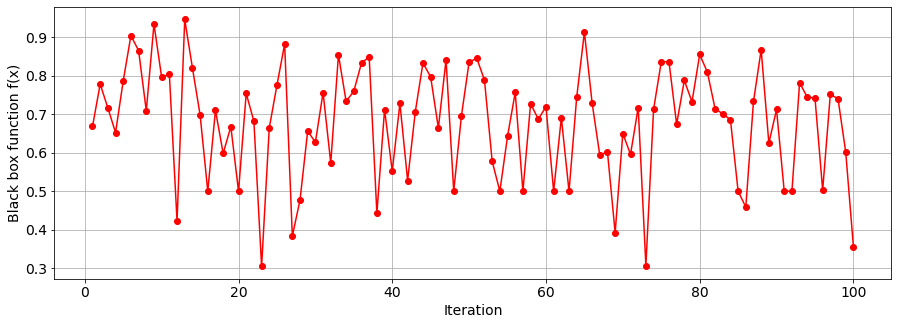

In [ ]:
print("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))
print()
print()
plt.figure(figsize = (15, 5))
print(optimizer.space.target)
plt.plot(range(1, 1 + len(optimizer.space.target)), optimizer.space.target, "-o", color='red')
plt.grid(True)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Black box function f(x)", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [ ]:
optimizer.maximize(init_points = 1, n_iter = 2)

|   iter    |  target   |   Batch   |   Bias    | Datase... | DropOu... |  EPOCHS   | Loss_F... | Model_... | Weight... | load_i... |    lr     | num_folds |
-------------------------------------------------------------------------------------------------------------------------------------------------------------


TypeError: ignored

In [ ]:
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

Best result: {'DropOut_Rate': 0.4931529940725688}; f(x) = 0.8088541666666667.


In [ ]:
from sklearn.model_selection import GridSearchCV
max_folds = np.arange(1,3,1)
param_grid = dict(max_folds=max_folds)
grid = GridSearchCV(estimator=Central_Room, param_grid=param_grid, cv=5)
grid.fit()

TypeError: ignored

# **Test Configuration for the Model**

In [ ]:
fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list, auc_roc2, auc_prc2, acc, acc2 = Evaluations(np.array(Real_labels), np.array(Predicted_Labels))

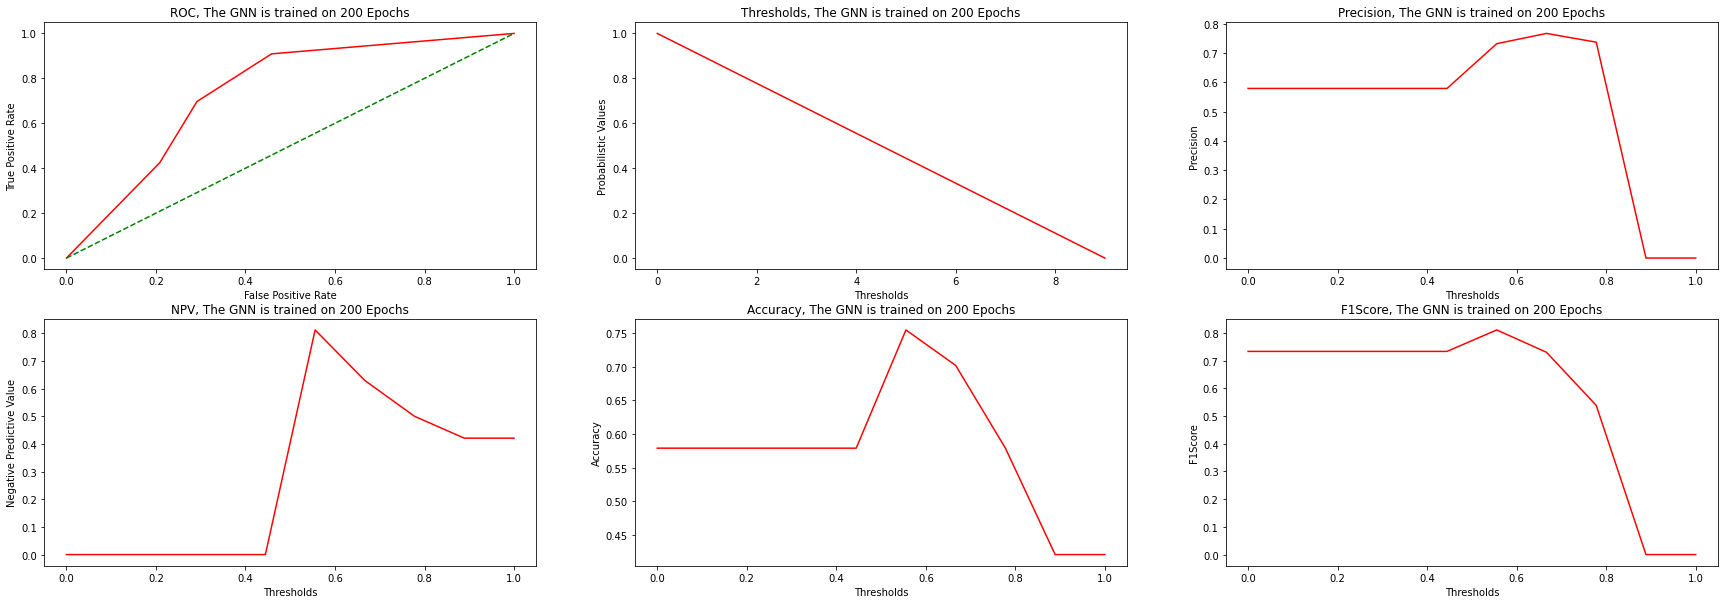

In [ ]:
#                   fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list
Evaluation_Plots([fpr, tpr, threshold, precision_list, npv_list, acc_list, f1score_list])

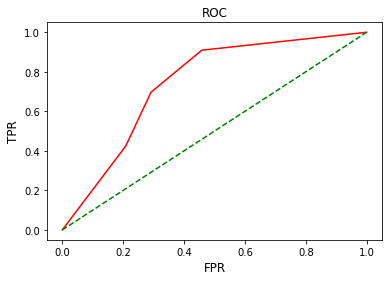

In [ ]:
plt.plot(fpr, tpr, 'r')
plt.plot([0,1],[0,1], 'g--')
plt.title("ROC")
plt.xlabel("FPR", fontsize=12)
plt.ylabel("TPR", fontsize=12)

plt.show()

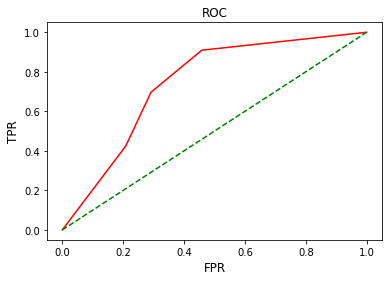

In [ ]:
plt.plot(fpr, tpr, 'r')
plt.plot([0,1],[0,1], 'g--')
plt.title("ROC")
plt.xlabel("FPR", fontsize=12)
plt.ylabel("TPR", fontsize=12)

plt.show()

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(real_labels, real_labels)

In [ ]:
print(fpr, tpr)
print(thresholds)

[0. 0. 1.] [0. 1. 1.]
[2 1 0]


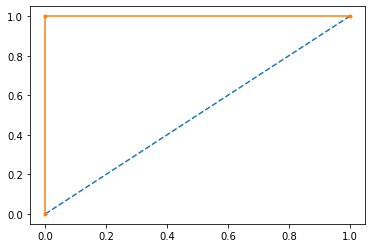

In [ ]:
from matplotlib import pyplot
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

In [ ]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  GCN_Model, GCN_Model_Optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index, GCN_Model_1, GCN_Model_Optimizer_1, Train_Dataset1)

In [ ]:
CrossEnt_criterion = torch.nn.CrossEntropyLoss()
MAE_criterion = torch.nn.L1Loss()
MSE_criterion = torch.nn.MSELoss()

def loss_calculations(preds, gtruth, Loss_Function):
    print("main: ", preds)
    print(gtruth)
    predss = torch.tensor_split(preds.reshape(len(preds), 2), 2, dim=1)
    #print("splitted0: ", preds[0])
    #print("splitted1: ", preds[1])
    if Loss_Function == 1:
        loss_per_epoch1 = CrossEnt_criterion(preds, gtruth).float()
        #print(loss_per_epoch1)
        return loss_per_epoch1

    elif Loss_Function == 2:
        loss_per_epoch2 = MAE_criterion(predss[1], gtruth).float()
        return loss_per_epoch2

    elif Loss_Function == 3:
        preds = preds.float()
        gtruth = gtruth.float()
        loss_per_epoch3 = MSE_criterion(predss[1], gtruth).float()
        #print("This is the Loss: ", loss_per_epoch3)
        return loss_per_epoch3